In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

tf.set_random_seed(0)
mnist = read_data_sets('data', one_hot=True, reshape=False, validation_size=0)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [2]:
def batchnorm(Y, is_test, i, offset, is_conv=False):
    ema = tf.train.ExponentialMovingAverage(0.999, i)
    if is_conv:
        # for conv layers compute moments across 3 dims (W, H, D)
        mean, variance = tf.nn.moments(Y, [0, 1, 2])
    else: 
        # for FC layers compute moments across just 1 dim
        mean, variance = tf.nn.moments(Y, [0])
    update_ma = ema.apply([mean, variance])
    
    # for test run use EMA and for train use the mean
    m = tf.cond(is_test, lambda: ema.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: ema.average(variance), lambda: variance)
    
    # note that scale is not needed for relu!
    Ybn = tf.nn.batch_normalization(Y, m, v, offset, None, variance_epsilon=1e-5)
    return Ybn, update_ma

In [3]:
# place holders for inputs/outputs
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y_true = tf.placeholder(tf.float32, [None, 10])

# learning rate
lr = tf.placeholder(tf.float32)
# batch norm during test?
bn_test = tf.placeholder(tf.bool)
# iteration counter
it = tf.placeholder(tf.int32)

In [5]:
# convolutional layer 1 hyperparms
F = 5 # filter size
S = 1 # stride
K = 4 # num filters

# fully connected layer
N = 200

# FxF filter, 1 input channel, K output channels
W1 = tf.Variable(tf.truncated_normal([F, F, 1, K], stddev=0.1))  
B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))

# fully connected layer, 28 * 28 * K inputs, N outputs (since 'SAME' padding will be used)
W2 = tf.Variable(tf.truncated_normal([28 * 28 * K, N], stddev=0.1))
B2 = tf.Variable(tf.constant(0.1, tf.float32, [N]))

# final layer of 10 nodes for 10 classes
W3 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
B3 = tf.Variable(tf.constant(0.1, tf.float32, [10]))

In [6]:
# The model

# conv layer
# no need for bias since batch norm is being performed!
Y1_conv = tf.nn.conv2d(X, W1, strides=[1, S, S, 1], padding='SAME')
# use bias as offset for batch norm
Y1bn, ema1 = batchnorm(Y1_conv, bn_test, it, B1, is_conv=True)
Y1 = tf.nn.relu(Y1bn)

# reshape the output from the conv layer for the FC layer
Y1_reshaped = tf.reshape(Y1, shape=[-1, 28 * 28 * K])
# no need for bias since batch norm is being performed!
Y2_fc = tf.matmul(Y1_reshaped, W2)
# use bias as offset for batch norm
Y2bn, ema2 = batchnorm(Y2_fc, bn_test, it, B2, is_conv=False)
Y2 = tf.nn.relu(Y2bn)

Y_logits = tf.matmul(Y2, W3) + B3
Y_pred = tf.nn.softmax(Y_logits)

# accumulate the moving averages
ema = tf.group(ema1, ema2)

In [9]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Y_logits, labels=Y_true)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

is_correct = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y_true, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

In [10]:
# training step
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

In [11]:
# start an interactive session
init = tf.global_variables_initializer()
ses = tf.InteractiveSession()
ses.run(init)

In [21]:
from ipywidgets import *
import bqplot.pyplot as plt

n = 200
acc_fig = plt.figure(title='Accuracy', legend_location='bottom-right')
x = np.arange(1, n+1)
axes_options = {'x': {'label': 'Iterations', 'num_ticks': 5},
                'y': {'tick_format': '.1%'}}
acc_plot = plt.plot(x, [], display_legend=True, 
                    labels=['Train', 'Test'], colors=['green', 'blue'],
                    axes_options=axes_options)

loss_fig = plt.figure(title='Loss')
loss_plot = plt.plot(np.arange(1, n+1), [], display_legend=True, 
                     labels=['Train', 'Test'], 
                     colors=['green', 'blue'],
                     axes_options={'x': {'label': 'Iterations', 
                                         'num_ticks': 5},
                                   'y': {'tick_format': ','}})
HBox([acc_fig, loss_fig])

A Jupyter Widget

In [22]:
from time import sleep

train_a = []
test_a = []
train_loss = []
test_loss = []

for i in range(200):
    batch_X, batch_Y = mnist.train.next_batch(100)
    
    # learning rate decay
    max_learning_rate = 0.02
    min_learning_rate = 0.0001
    decay_speed = 1600
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * np.exp(-i / decay_speed)

    # train
    ses.run(train_step, {X: batch_X,
                         Y_true: batch_Y, 
                         lr: learning_rate, 
                         bn_test: False})
    ses.run(ema, {X: batch_X, 
                  Y_true: batch_Y, 
                  bn_test: False, 
                  it: i})
    a, c = ses.run([accuracy, cross_entropy], 
                   feed_dict={X: batch_X, 
                              Y_true: batch_Y,
                              bn_test: False})
    train_a.append(a)
    train_loss.append(c * 100)
    
    # run on test data
    test_data = {X: mnist.test.images, 
                 Y_true: mnist.test.labels,
                 bn_test: True}
    a, c = ses.run([accuracy, cross_entropy], feed_dict=test_data)
    test_a.append(a)
    test_loss.append(c)
    
    sleep(.001)
    acc_plot.y = [train_a, test_a]
    loss_plot.y = [train_loss, test_loss]

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

In [25]:
# true test labels
y_true = np.argmax(mnist.test.labels, 1)
test_data = {X: mnist.test.images, Y_true: mnist.test.labels, bn_test: True}

# pred test labels
y_pred = np.argmax(ses.run(Y_pred, feed_dict=test_data), 1)

In [26]:
conf_mat = confusion_matrix(y_true, y_pred)

In [64]:
from bqplot import *

class SquareMatrix(Figure):
    def __init__(self, *args, **kwargs):
        self.conf_mat = kwargs['matrix']
        self.title = kwargs.get('title', '')
        n = len(self.conf_mat)
        self.labels = kwargs.get('labels', np.arange(n))
        row_scale = OrdinalScale(reverse=True)
        col_scale = OrdinalScale()
        color_scale = ColorScale(scheme='Greens')
        row_axis = Axis(scale=row_scale, orientation='vertical', label='Actual Label')
        col_axis = Axis(scale=col_scale, label='Predicted Label')
        self.conf_mat_grid = GridHeatMap(
            column=self.labels,
            row=self.labels,
            color=(self.conf_mat ** .3),
            scales={'row': row_scale, 'column': col_scale, 'color': color_scale},
            interactions={'click': 'select'},
            anchor_style={'stroke': 'red', 'stroke-width': 3},
            selected_style={'stroke': 'red'})

        y, x, text = zip(*[(self.labels[i],
                            self.labels[j],
                            str(self.conf_mat[i, j])) for i in range(n) for j in range(n)])

        self.grid_labels = Label(x=x, y=y, text=text,
                                 scales={'x': col_scale, 
                                         'y': row_scale},
                                 font_size=16,
                                 align='middle',
                                 colors=['black'])

        self.title = 'Confusion Matrix'
        self.marks = [self.conf_mat_grid, self.grid_labels]
        self.padding_y = 0.0
        self.axes = [row_axis, col_axis]
        self.fig_margin = dict(left=50, top=40, bottom=40, right=20)
        self.layout.width = '460px'
        self.layout.height = '400px'
        
        super(SquareMatrix, self).__init__(*args, **kwargs)

In [66]:
cm = SquareMatrix(matrix=conf_mat)
cm

A Jupyter Widget

In [67]:
true, pred = cm.conf_mat_grid.selected[0]
true, pred

(2, 3)

[  72  149  244  318  629 1016 1050 1374 1459 1462 1609 1682 2186 2496 2517
 2780 2959 3375 3681 3811 4100 4350 4997 5167 6528 7619 7627 8584 9613 9768
 9811]


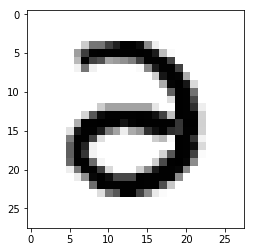

In [72]:
import matplotlib.pyplot as plt1
%matplotlib inline

X = np.squeeze(mnist.test.images)

idx = np.argwhere((y_true == true) & (y_pred == pred)).squeeze()
print(idx)
plt1.imshow(X[idx[15]], cmap='binary')